In [1]:
"""
=================
Lifetime analysis
=================
Fit a decay to photons in pixel to determine a mean fluorescence lifetime.
"""
import numpy as np
import pylab as plt
import tqdm
import pandas as pd

import tttrlib

In [2]:
# %%
# The fit operates on a parallel and a perpendicular detection
# channel. Here we define the channel numbers of the two channels
# and read the tttr data of the clsm experiment. Moreover, we define
# a binning factor that is used to coarsen the micro time.
ch_p = [0]
ch_s = [1]
binning_factor = 128
minimum_n_photons = 10

fn_clsm = './tttr-data/imaging/pq/ht3/crn_clv_img.ht3'
data = tttrlib.TTTR(fn_clsm)

In [3]:
# %%
# Next we create two CLSM container for the parallel and perpendicular
# channel and stack frames to have more photons in each pixels.
clsm_p = tttrlib.CLSMImage(data, channels=ch_p, fill=True)
clsm_s = tttrlib.CLSMImage(data, channels=ch_s, fill=True)

In [4]:
clsm_p.tttr

tttrlib.TTTR("/home/tpeulen/dev/tttrlib/tttr-data/imaging/pq/ht3/crn_clv_img.ht3", "HT3")

In [5]:
# %%
# We determine instrument response function in parallel and perpendicular
# detection channels.
fn_irf = './tttr-data/imaging/pq/ht3/crn_clv_mirror.ht3'
irf_tttr = tttrlib.TTTR(fn_irf)
irf_data_p: tttrlib.TTTR = irf_tttr[irf_tttr.get_selection_by_channel(ch_p)]
irf_data_s: tttrlib.TTTR = irf_tttr[irf_tttr.get_selection_by_channel(ch_s)]

In [6]:
# %%
# We get micro time histograms for the IRF and stack the histograms
irf_p, t = irf_data_p.get_microtime_histogram(binning_factor)
irf_s, _ = irf_data_s.get_microtime_histogram(binning_factor)
irf = np.hstack([irf_p, irf_s])

In [7]:
# %%
# The settings are used to initialize an instance of the class ``Fit23``. A dataset
# is fitted by calling an instance of ``Fit23`` using the data, an array of the initial
# values of the fitting parameters, and an array that specifies which parameters are
# fixed.

settings = {
    'dt': data.header.micro_time_resolution * 1e9 * binning_factor,
    'g_factor': 1.0, 'l1': 0.05, 'l2': 0.05,
    'convolution_stop': -1,
    'irf': irf,
    'period': 32.0,
    'background': np.zeros_like(irf)
}

fit23 = tttrlib.Fit23(**settings)
tau, gamma, r0, rho = 1.2, 0.02, 0.38, 10.0
x0 = np.array([tau, gamma, r0, rho])
fixed = np.array([0, 0, 1, 1])

In [8]:
clsm_p

tttrlib.CLSMImage(40, 256, 256)

In [9]:
l = clsm_p[0][0]
print(list(l.start_stop))
start = l.tttr_indices[0]
stop = l.tttr_indices[-1]
print(start, stop)

[1552, 1643]
1552 1643


In [10]:
list(l.tttr_indices)

[1552, 1643]

In [11]:
clsm_p.tttr.macro_times[l.start]

44874881

In [12]:
px = clsm_p[0][0][0]
clsm_p.get_line_duration(0, 0)

5.119636359193172

In [13]:
clsm_p.tttr.macro_times[stop]

45038709

In [14]:
clsm_p.tttr.macro_times[start]

44874881

In [15]:
clsm_p.pixel_duration

0.019998579528098328

In [16]:
data.macro_times[stop] - data.macro_times[start]

163828

In [17]:
(data.macro_times[stop] - data.macro_times[start]) * data.header.macro_time_resolution * 1000.0 / 256

0.019998579528098328

In [18]:
data.header.macro_time_resolution

3.125006933609134e-08

In [19]:
data.header.get_pixel_duration()
clsm_p.line_duration

5.119636359193172

In [17]:
df_pg4 = pd.DataFrame()

In [7]:
# %%
# We iterate over all pixels in the image and apply the fit to
# pixels where we have at certain minimum number of photons
n_frames, n_lines, n_pixel = clsm_p.shape
tau = np.zeros(clsm_p.shape, dtype=np.float32)
n_frames, n_lines, n_pixel = clsm_p.shape
for f in tqdm.tqdm(range(n_frames)):
    for y in range(0, n_lines):
        for c in range(n_pixel):
            Ng_p_all = clsm_p[f][y][x].size()
            Ng_s_all = clsm_s[f][y][x].size()
            Ng_all = Ng_p_all + Ng_s_all
            if Ng_all > minimum_n_photons:
                hist = np.hstack(
                    [
                        clsm_p[i][j][k].get_microtime_histogram(data, binning_factor)[0], 
                        clsm_s[i][j][k].get_microtime_histogram(data, binning_factor)[0]
                    ]
                )
                r = fit23(hist, x0, fixed)
            tau[i, j, k] = r['x'][0]
            pg4_row = {
                "Frame": f, 
                "Pixel Number": y * n_lines + x, 
                "Y pixel": y, 
                "X pixel": x, 
                "Green Count Rate (KHz)": , 
                "Number of Photons (green)": Ng_all, 
                "Number of Photons (fit window) (green)": Ng_all,
                "tau (green)": r['x'][0],
                "gamma (green)": r['x'][1],
                "r0 (green)": r['x'][2],
                "rho (green)": r['x'][3],
                "BIFL scatter fit? (green)": r['x'][4],
                "2I*: P+2S? (green)": r['x'][5],
                "rS (green)": r['x'][6],
                "rE (green)": r['x'][7],
                "2I* (green)": r['twoIstar'],
                "Ng-p-all": Ng_p_all,
                "Ng-s-all": Ng_s_all,
                "Ng-all": Ng_all
            }
            df_pg4.append(pg4_row)

100%|██████████| 40/40 [00:56<00:00,  1.42s/it]


In [25]:
r['x']

array([ 2.98324177,  0.        ,  0.38      , 10.        , -1.        ,
        0.        , -0.28818444, -0.28818444])

In [8]:
# %%
# Plot for the last fit result the data and the optimized model

/opt/tljh/user/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/tljh/user/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


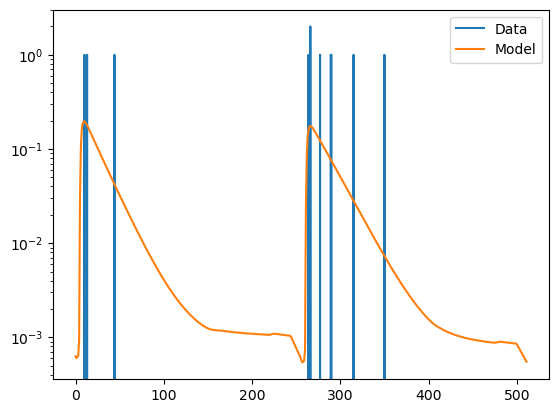

In [9]:
plt.semilogy(hist, label="Data")
plt.semilogy(fit23.model, label="Model")
plt.legend()

In [10]:
# %%
# Histogram over lifetimes

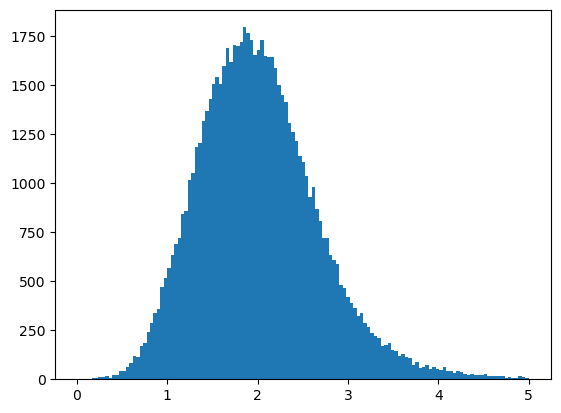

In [11]:
plt.hist(tau.flatten(), 131, range=(0.01, 5))
plt.show()

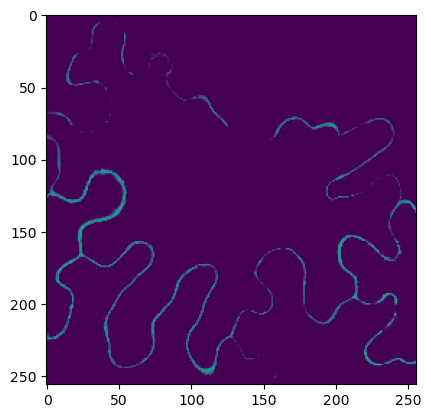

In [12]:
plt.imshow(tau.mean(axis=0), vmin=0.1, vmax=4.0)
plt.show()